#  Прогнозирование заказов такси

## Описание работы

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План проведения работ

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»). Первым столбцом идут дата и время заказа с шагом 10 минут.

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import copy

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

import lightgbm as lgb

Объявим глобальные переменные.

In [2]:
SEED = 314159

Загрузим данные.

In [3]:
if os.path.exists('taxi.csv'):
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Сделаем первичный осмотр.

In [4]:
df.info()
display(df.head())
display(df.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Проверим в хронологическом ли порядке размещены дата и время.

In [5]:
df.index.is_monotonic

True

Построим график с количеством заказов.

<AxesSubplot:xlabel='datetime'>

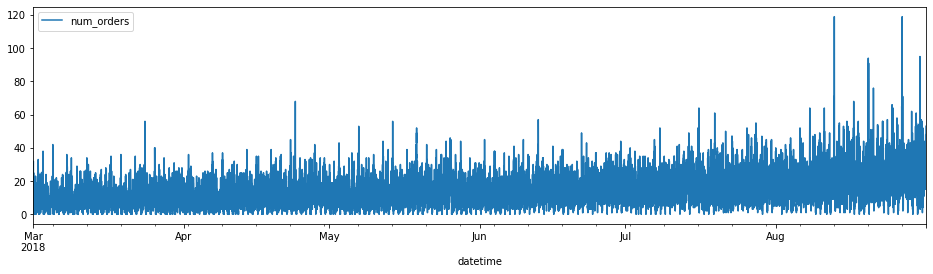

In [6]:
plt.figure(figsize=(16, 4))
df.plot(ax=plt.gca())

### Выводы

Мы загрузили данные с начала марта 2018 по конец августа, проверили на пропуски и монотонность.

График зависимости количества заказов от времени ожидаемо оказался "частоколом". Применим другие подходы при анализе данных.

## Анализ

Для начала проведём ресемплирование по одному часу.

<AxesSubplot:xlabel='datetime'>

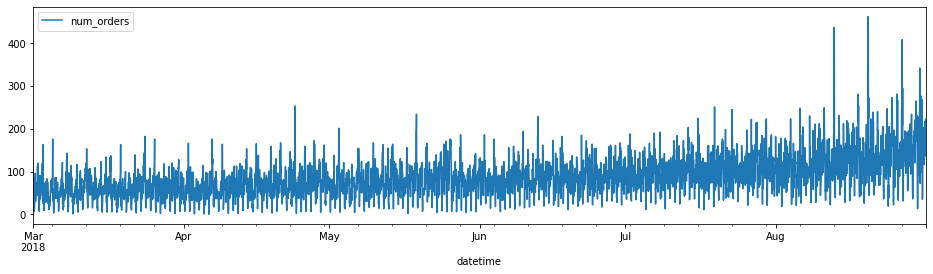

In [7]:
plt.figure(figsize=(16, 4))
df = df.resample('1H').sum()
df.plot(ax=plt.gca())

Вычислим скользящее среднее взяв данные за 24 часа.

In [ ]:
plt.figure(figsize=(16, 4))
df['rolling_mean'] = df.shift().rolling(24).mean()

fig = px.line(df, title='Разности временного ряда')
fig.update_xaxes(rangeslider_visible=True)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label='1 week', step='day', stepmode='backward'),
            dict(count=1, label='1 month', step='month', stepmode='backward'),
            dict(step='all')
        ])
    )
)
fig.show()

На графике можно заметить восходящий тренд. Попробуем сделать его более явным. Разделим на тренды и сезонные явления.

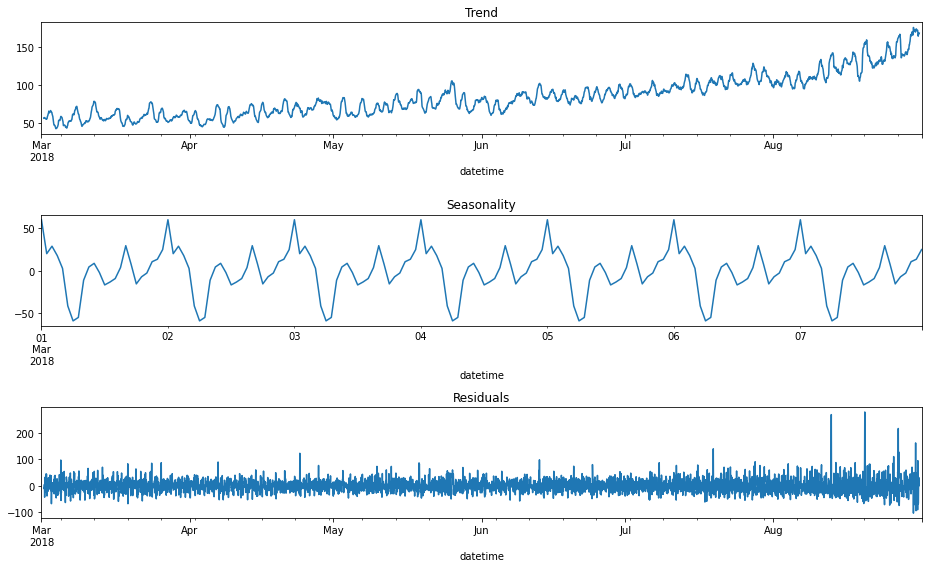

In [9]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(13, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.loc['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике тренда видно что количество заказов постепенно повышается ближе к концу лета (сезон отпусков). Видны внутридневные колебания, есть некоторый "шум".

Т.к. среднее значение меняется - наш ряд не стационарный, попробуем найти разности временного ряда.

In [ ]:
# создадим копию исходного датасета
df_init = copy.deepcopy(df.drop(columns='rolling_mean'))
                                
shift = df.shift()
df = df - shift
df['std'] = df['num_orders'].shift().rolling(24).std()

fig = px.line(df, title='Разности временного ряда')
fig.update_xaxes(rangeslider_visible=True)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label='1 week', step='day', stepmode='backward'),
            dict(count=1, label='1 month', step='month', stepmode='backward'),
            dict(step='all')
        ])
    )
)
fig.show()

df.drop(columns=['rolling_mean', 'std'], inplace=True)

### Выводы

Мы проанализировали наш временной ряд, можно заметить селедующие закономерности:
   * виден восходящий тренд от марта к сентябрю, сильный в августе, вероятно сезон отпусков
   * видно увеличение количества заказов в понедельник с вечера и до утра, вероятно прилёты перед началом рабочей недели
   * также видны внутридневные пики около 10 утра и 17 вечера
   
Вычислили разности временного ряда и теперь он почти полностью стационарный (немного увеличивается стандартное отклонение ближе к концу августа). Можно переходить к подготовке к обучению.

## Обучение

### Добавление признаков и разбиение на выборки

Добавим обучающих признаков в наш датасет.

In [11]:
# напишем функцию для добавления новых признаков
def make_features(data, max_lag, rolling_mean_size):
    
    # добавим календарные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek.astype('category')
    
    # добавим время суток
    data.loc[(data.index.hour >= 0) & (data.index.hour < 6), 'times_of_day'] = 'night'
    data.loc[(data.index.hour >= 6) & (data.index.hour < 12), 'times_of_day'] = 'morning'
    data.loc[(data.index.hour >= 12) & (data.index.hour < 18), 'times_of_day'] = 'day'
    data.loc[(data.index.hour >= 18) & (data.index.hour < 24), 'times_of_day'] = 'evening'
    data['times_of_day'] = data['times_of_day'].astype('category')
    
    # добавим сдвиги
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['lag_week'] = data['num_orders'].shift(24 * 7)
        
    # добавим скользящее среднее
    data['rolling_mean_{}'.format(rolling_mean_size)] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 24, 24)
df.dropna(inplace=True)

# применим к исходному датасету те же преобразования что и к дифференцированному для сравнения на тесте
make_features(df_init, 24, 24)
df_init.dropna(inplace=True)

Разделим данные признаки и цели, на обучающую и тестовые выборки.

In [12]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

X, X_test, y, y_test= train_test_split(X, y, shuffle=False, test_size=0.1)

In [13]:
X.index[-1]

Timestamp('2018-08-14 06:00:00', freq='H')

In [14]:
X_test.index[0]

Timestamp('2018-08-14 07:00:00', freq='H')

In [15]:
print(f'Доля тренировочных признаков: {X.shape[0]/df.shape[0]:.2f}')
print(f'Доля тренировочных целей: {y.shape[0]/df.shape[0]:.2f}')
print(f'Доля тестовых признаков: {X_test.shape[0]/df.shape[0]:.2f}')
print(f'Доля тестовых целей: {y_test.shape[0]/df.shape[0]:.2f}')

Доля тренировочных признаков: 0.90
Доля тренировочных целей: 0.90
Доля тестовых признаков: 0.10
Доля тестовых целей: 0.10


Даты не перемешались и разбились в верных пропорциях, приступим к изучению моделей.

### Baseline

Найдём результаты для константной модели.

Создадим генератор кросс-валидационных наборов, зададим сетку параметров, определим модель и оценщик GridSearch.

In [16]:
tscv = TimeSeriesSplit(n_splits=3, gap=(24 * 7))

param_grid = {
    'strategy':['median', 'mean']
}

model = DummyRegressor()

gs_dr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

Проведём обучение.

In [17]:
%time gs_dr.fit(X, y)
None

Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: user 20 ms, sys: 38 µs, total: 20 ms
Wall time: 19.1 ms


Посмотрим на результат и залогируем результат.

In [18]:
table = pd.DataFrame(gs_dr.cv_results_)

results = {} # словарь со сводными результатами для всех моделей
results['Dummy Regressor'] = int(abs(table[table['rank_test_score'] == 1]['mean_test_score'].values[0]))

table[[
    'param_strategy',
    'mean_test_score', 'rank_test_score'
]]

,param_strategy,mean_test_score,rank_test_score
0,median,-38.367936,2
1,mean,-38.341111,1


Попробуем линейную регрессию.

### LinearRegression

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [19]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include=['category', 'object'])
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

Соберём pipeline для линейной регрессии.

In [20]:
pipe_lr = make_pipeline(
    linear_transformer,
    LinearRegression(
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим оценщик.

In [21]:
param_grid = {
    'linearregression__normalize':[False, True]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

Проведём обучение.

In [22]:
%time gs_lr.fit(X, y)
None

Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: user 861 ms, sys: 1.1 s, total: 1.96 s
Wall time: 1.96 s


Посмотрим на результат и залогируем результат.

In [23]:
table = pd.DataFrame(gs_lr.cv_results_)

results['Linear Regression'] = int(abs(table[table['rank_test_score'] == 1]['mean_test_score'].values[0]))

table[[
    'param_linearregression__normalize',
    'mean_test_score', 'rank_test_score'
]]

,param_linearregression__normalize,mean_test_score,rank_test_score
0,False,-26.260517,2
1,True,-26.254378,1


Попробуем случайный лес.

### RandomForestRegressor

Создадим трансформер для различных колонок, в случае с "деревянными моделями" к категориальным применим OE, числовые оставим как есть.

In [24]:
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include=['object', 'category'])
    ),
    remainder='passthrough'
)

Создадим pipeline.

In [25]:
pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestRegressor(
        oob_score=True,
        n_jobs=-1,
        verbose=0,
        random_state=SEED
    )
)

Зададим сетку параметров и создадим estimator.

In [26]:
param_grid = {
    'randomforestregressor__max_depth':np.arange(5, 16, 5)
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

Проведём обучение.

In [27]:
%time gs_rf.fit(X, y)
None

Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 20.9 s, sys: 111 ms, total: 21 s
Wall time: 21 s


Посмотрим на результат и залогируем результат.

In [28]:
table = pd.DataFrame(gs_rf.cv_results_)

results['Random Forest Regressor'] = int(abs(table[table['rank_test_score'] == 1]['mean_test_score'].values[0]))

table[[
    'param_randomforestregressor__max_depth',
    'mean_test_score', 'rank_test_score'
]]

,param_randomforestregressor__max_depth,mean_test_score,rank_test_score
0,5,-28.520888,3
1,10,-27.884180,2
2,15,-27.846876,1


Результат сравним с линейной моделью, посмотрим на модель LinearSVR.

### LinearSVR

Создадим pipeline для модели.

In [29]:
pipe_svr = make_pipeline(
    linear_transformer,
    LinearSVR(
        random_state=SEED
    )
)

Зададим сетку параметров и создадим estimator.

In [30]:
c_values = np.logspace(-2, 2, 10)

param_grid = {
    'linearsvr__C':c_values
}

gs_svr = GridSearchCV(
    pipe_svr,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [ ]:
%time gs_svr.fit(X, y)
None

Посмотрим на результат и залогируем результат.

In [32]:
table = pd.DataFrame(gs_svr.cv_results_)

results['Linear Support Vector Regression'] = int(abs(table[table['rank_test_score'] == 1]['mean_test_score'].values[0]))

table[[
    'param_linearsvr__C',
    'mean_test_score', 'rank_test_score'
]]

,param_linearsvr__C,mean_test_score,rank_test_score
0,0.01,-31.805792,10
1,0.027826,-28.660469,9
2,0.077426,-27.117255,8
3,0.215443,-26.685392,2
4,0.599484,-26.602441,1
5,1.668101,-26.714671,4
6,4.641589,-26.724352,5
7,12.915497,-26.739248,6
8,35.938137,-26.708344,3
9,100.0,-26.837302,7


Результат сравним с линейной моделью, воспользуемся бустингом.

### LightGBM

Для работы с библиотекой необходимо перевести все категориальные признаки в целые числа. Воспользуемся определённым ранее трансформером для ансамблей.

Создадим pipeline для регрессора LightGBM.

In [33]:
pipe_gbm = make_pipeline(
    ensemble_transformer,
    lgb.LGBMRegressor(
        metric='rmse',
        n_jobs=-1,
        verbosity=-1,
        random_state=SEED
    )
)

Зададим сетку параметров и создадим оценщик.

In [34]:
param_grid = {
    'lgbmregressor__max_depth':[-1, 10, 20],
    'lgbmregressor__num_leaves':[10, 31],
    'lgbmregressor__learning_rate':[.1, .5]
}
              
gs_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [35]:
%time gs_gbm.fit(X, y)
None

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: user 35.3 s, sys: 0 ns, total: 35.3 s
Wall time: 36.1 s


Посмотрим на результат и залогируем результат.

In [36]:
table = pd.DataFrame(gs_gbm.cv_results_)

results['LightGBM Regressor'] = int(abs(table[table['rank_test_score'] == 1]['mean_test_score'].values[0]))

table[[
    'param_lgbmregressor__max_depth', 'param_lgbmregressor__num_leaves', 'param_lgbmregressor__learning_rate',
    'mean_test_score', 'rank_test_score'
]]

,param_lgbmregressor__max_depth,param_lgbmregressor__num_leaves,param_lgbmregressor__learning_rate,mean_test_score,rank_test_score
0,-1,10,0.1,-27.033481,1
1,-1,31,0.1,-27.163744,6
2,10,10,0.1,-27.033481,1
3,10,31,0.1,-27.112229,4
4,20,10,0.1,-27.033481,1
5,20,31,0.1,-27.146835,5
6,-1,10,0.5,-29.152740,7
7,-1,31,0.5,-29.373620,10
8,10,10,0.5,-29.152740,7
9,10,31,0.5,-29.427638,12


### Выводы

Посмотрим на сводную таблицу с результатами.

In [37]:
pd.DataFrame(
    results, index=['RMSE на кросс-валидации для смещённого датасета']
).transpose()

,RMSE на кросс-валидации для смещённого датасета
Dummy Regressor,38
Linear Regression,26
Random Forest Regressor,27
Linear Support Vector Regression,26
LightGBM Regressor,27


Мы исследовали разные модели на полученном датасете. Все они лучше базовой. Проверим лучшую тестовом датасете.

## Тестирование

Выберем для оценки на тесте модель LinearRegression.

In [38]:
prediction_lr = gs_lr.predict(X_test) + shift['num_orders'][-y_test.shape[0]:] # получаем несмещённую ошибку
rmse_lr = int(mean_squared_error((y_test + shift['num_orders'][-y_test.shape[0]:]), prediction_lr, squared=False))
print(f'Метрика RMSE на дифференцированном датасете составила {rmse_lr} заказов в час.')

Метрика RMSE на дифференцированном датасете составила 38 заказов в час.


Также проверим эту модель с не дефиренцированным датасетом.

In [39]:
X = df_init.drop(['num_orders'], axis=1)
y = df_init['num_orders']

X, X_test, y, y_test= train_test_split(X, y, shuffle=False, test_size=0.1)

gs_lr.fit(X, y)

prediction_lr = gs_lr.predict(X_test)
rmse_lr = int(mean_squared_error(y_test, prediction_lr, squared=False))
print(f'Метрика RMSE на не дифференцированном датасете составила {rmse_lr} заказов в час.')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Метрика RMSE на не дифференцированном датасете составила 34 заказов в час.


## Заключение

Для компания «Чётенькое такси» мы разработали модель которая спрогнозировала количество заказов такси на следующий час на основе исторических данных о заказах такси в аэропортах.

    Мы загрузили данные и выполнили их ресемплирование по одному часу.
    Проанализировали данные. Выявили тренд, сезонность и шумы. Продиферринцировали данные для получения стационарного ряда.
    Обучили различные модели с различными гиперпараметрами и выбрали лучшую.
    Проверили работу выбранной модели на тестовой выборке. Сравнили стационарный и исходный ряд.
    
С моделью Linear Regression мы получили желаемый RMSE как на стационарном ряде, так и на исходном. При этом, в данном конкретном случае недиферренцированные данные показали лучший результат.